In [57]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import rbf_kernel
try:    
    import statsmodels.api as sm
except ImportError:
    !pip install statsmodels
    import statsmodels.api as sm


In [58]:
data_5 = pd.read_csv('data/data5.csv')
data_80 = pd.read_csv('data/data80.csv')
data_5.describe()


,value
count,501.000000
mean,57.474207
std,20.659715
min,5.000000
25%,42.216692
50%,64.102030
75%,72.038830
max,91.205139


In [59]:

def mmd_statistic(X, Y, gamma=None):
    """Calculate the MMD statistic between two samples X and Y using RBF kernel"""
    XX = rbf_kernel(X, X, gamma)
    YY = rbf_kernel(Y, Y, gamma)
    XY = rbf_kernel(X, Y, gamma)
    
    n = X.shape[0]
    m = Y.shape[0]
    
    # Calculate MMD^2
    mmd_squared = (np.sum(XX) - np.trace(XX)) / (n * (n - 1))
    mmd_squared += (np.sum(YY) - np.trace(YY)) / (m * (m - 1))
    mmd_squared -= 2 * np.sum(XY) / (n * m)
    
    return np.sqrt(max(mmd_squared, 0))  # Return MMD (not squared)


In [60]:
def change_points_predict(data, window_size=3,plot =True):
    data['index'] = range(1, len(data)+1)

 
    for i in range(2*window_size, len(data), window_size): # i denotes the present index
        if i == 2*window_size:
            X = data.iloc[i-2*window_size: i-window_size]['index']
            Y = data.iloc[i-2*window_size: i-window_size]['value']
            X = sm.add_constant(X)
            model = sm.OLS(Y, X)
            results = model.fit()
        
        # predict the past window
        X_predict = data.iloc[i-window_size: i]['index']
        data.iloc[i-window_size: i, data.columns.get_loc('predicted_value')] = results.predict(X_predict)    
    
    
    #mmd detection
    # Use median heuristic for kernel bandwidth if not specified
        if not gamma:
            X = np.vstack([data.iloc[i-window_size: i]['value'], data.iloc[i-window_size: i]['predicted_value']])
            dists = rbf_kernel(X, X)
            gamma = 1.0 /  np.median(dists[dists > 0])
        
        mmd = mmd_statistic(data.iloc[i-window_size: i]['value'], data.iloc[i-window_size: i]['predicted_value'], gamma)
        past_data = data.iloc[i-2*window_size: i]['value']
        threshold = np.percentile(past_data, 90)   
        
        changepoints = []
        changepoints_present = False
        if mmd > threshold:
            changepoints_present = True
            #print(f"Change point detected during index {(i-1)*window_size, (i)*window_size+window_size}")
            changepoints.append(i)
        
        if changepoints_present:
            # refit the model
            X = data.iloc[i-window_size: i]['index']
            Y = data.iloc[i-window_size: i]['value']
            X = sm.add_constant(X)
            model = sm.OLS(Y, X)
            results = model.fit()
            data.iloc[i-window_size: i, data.columns.get_loc('predicted_value')] = results.predict(X)
    
    # plot the data
        if plot:
            plt.figure(figsize=(10, 6))
            plt.plot(data['index'], data['value'], label='Original Data')
            plt.plot(data['index'], data['predicted_value'], label='Predicted Data')
            plt.scatter(changepoints, data.loc[changepoints, 'value'], color='red', label='Change Points')
            plt.legend()
            plt.show()

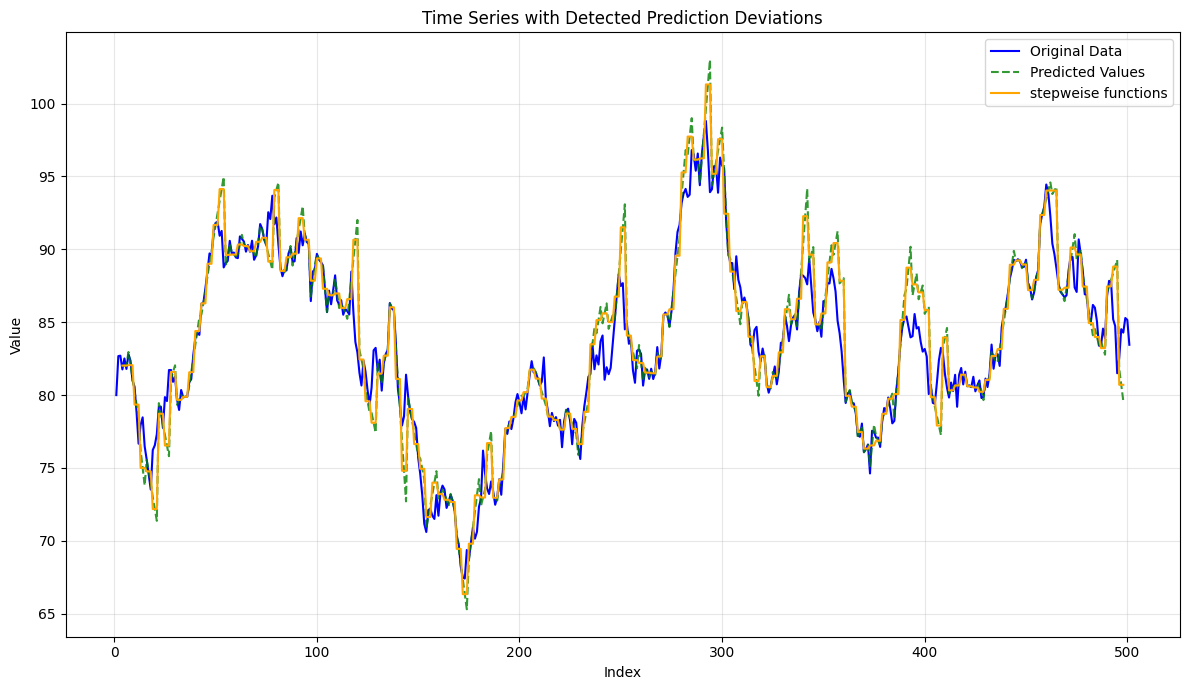

MSE for predicted value 3.7950304065607634
MSE for stepwise value 3.749737603267662


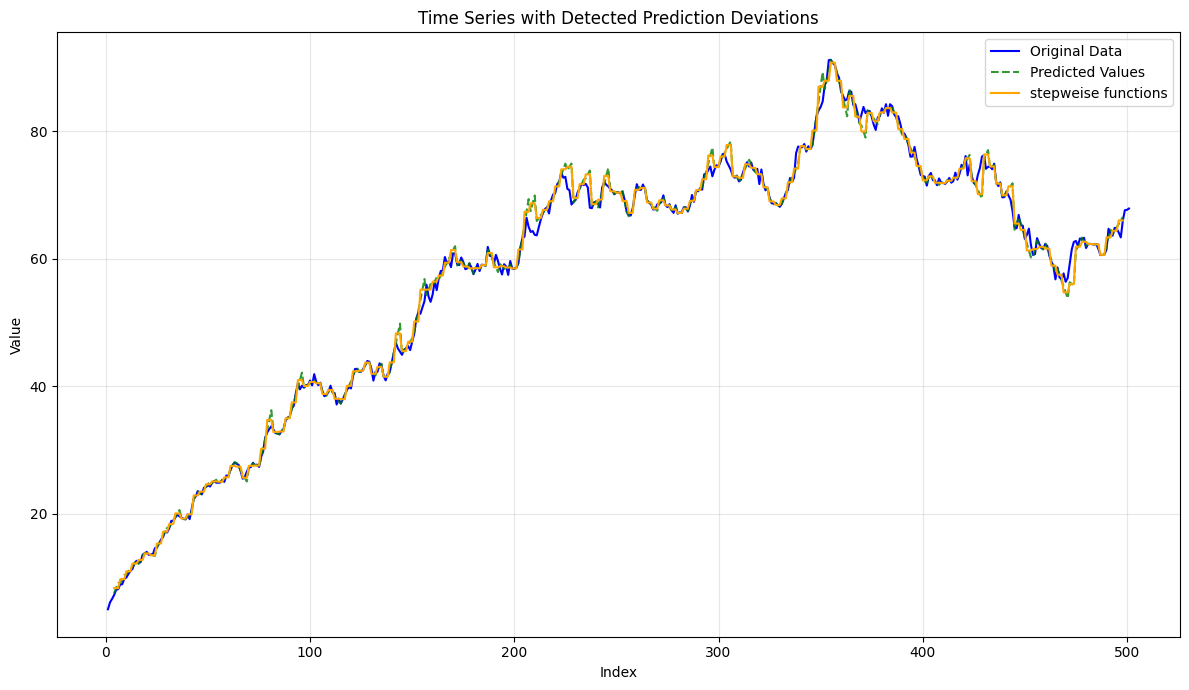

MSE for predicted value 1.600923708743947
MSE for stepwise value 1.7085406554702955


In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics.pairwise import rbf_kernel

def mmd_statistic(x, y, gamma):
    """
    Compute the Maximum Mean Discrepancy (MMD) between two samples.
    
    Parameters:
    -----------
    x : array-like
        First sample
    y : array-like
        Second sample
    gamma : float
        RBF kernel bandwidth parameter
        
    Returns:
    --------
    float
        MMD statistic value
    """
    x = np.array(x).reshape(-1, 1)
    y = np.array(y).reshape(-1, 1)
    
    # Compute kernel matrices
    k_xx = rbf_kernel(x, x, gamma)
    k_yy = rbf_kernel(y, y, gamma)
    k_xy = rbf_kernel(x, y, gamma)
    
    # Compute MMD
    n = len(x)
    m = len(y)
    
    mmd = (np.sum(k_xx) - np.trace(k_xx)) / (n * (n - 1))
    mmd += (np.sum(k_yy) - np.trace(k_yy)) / (m * (m - 1))
    mmd -= 2 * np.sum(k_xy) / (n * m)
    
    return mmd

def prediction_deviation_analysis(data, window_size=3, gamma=None, plot=True):
    """
    Analyze deviations between predicted model values and actual data using Maximum Mean Discrepancy (MMD).
    
    Parameters:
    -----------
    data : pandas.DataFrame
        DataFrame containing 'value' column with time series data
    window_size : int, optional (default=3)
        Size of sliding window for analysis
    gamma : float, optional (default=None)
        RBF kernel bandwidth parameter. If None, calculated using median heuristic
    plot : bool, optional (default=True)
        Whether to plot the results
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with original data, predicted values and deviation points detected
    list
        List of detected significant deviation indices
    """
    # Create a copy to avoid modifying the original data
    data = data.copy()
    
    # Add index column if not exists
    if 'index' not in data.columns:
        data['index'] = range(1, len(data) + 1)
    
    # Initialize predicted values column
    if 'predicted_value' not in data.columns:
        data['predicted_value'] = np.nan
    
    # Store all detected deviation points
    all_deviation_points = []
    
    # Need at least 2*window_size data points to start
    if len(data) < 2 * window_size:
        print(f"Warning: Data length ({len(data)}) is less than 2*window_size ({2*window_size})")
        return data, all_deviation_points
    
    # Initialize the model with first window
    X = data.iloc[:window_size]['index']
    Y = data.iloc[:window_size]['value']
    X = sm.add_constant(X)
    model = sm.OLS(Y, X)
    results = model.fit()
    
    for i in range(2*window_size, len(data), window_size):
        # Use past window to predict current window
        X_predict = sm.add_constant(data.iloc[i-window_size:i]['index'])
        data.loc[data.index[i-window_size:i], 'predicted_value'] = results.predict(X_predict)
        data.loc[data.index[i-window_size:i], 'stepwise_value'] = data.loc[data.index[i-window_size:i], 'predicted_value'].mean()
        # MMD detection - determine if distributions are different
        
        if gamma is None:
            # Use median heuristic for kernel bandwidth
            X_vals = np.vstack([
                data.iloc[i-window_size:i]['value'].values.reshape(-1, 1), 
                data.iloc[i-window_size:i]['predicted_value'].values.reshape(-1, 1)
            ])
            dists = rbf_kernel(X_vals, X_vals)
            gamma_val = 1.0 / np.median(dists[dists > 0])
        else:
            gamma_val = gamma
        
        # Calculate MMD between actual and predicted values
        mmd = mmd_statistic(
            data.iloc[i-window_size:i]['value'], 
            data.iloc[i-window_size:i]['predicted_value'], 
            gamma_val
        )
        
        # Use past data to determine threshold
        threshold = 0.1
        # if i >= 2*window_size:
        #     past_data = data.iloc[:i-window_size]['value']
        #     # threshold = np.percentile(past_data, 98)  
        # else:
        #     # If not enough past data, use current window
        #     # threshold = np.percentile(data.iloc[i-window_size:i]['value'], 98)
        # print('mmd', mmd)
        # Check if significant deviation detected
        if mmd > threshold:
            # print('test')

            # Record i-window_size as a deviation point
            deviation_point_idx = data.index[i-window_size]
            all_deviation_points.append(deviation_point_idx)
            
            # Refit model with current window for future predictions
            X = data.iloc[i-window_size:i]['index']
            Y = data.iloc[i-window_size:i]['value']
            X = sm.add_constant(X)
            model = sm.OLS(Y, X)
            results = model.fit()
            X_predict = sm.add_constant(data.iloc[i-window_size:i]['index'])
            data.loc[data.index[i-window_size:i], 'predicted_value'] = results.predict(X_predict)
            data.loc[data.index[i-window_size:i], 'stepwise_value'] = data.loc[data.index[i-window_size:i], 'predicted_value'].mean()
        else :
            if all_deviation_points == []:
                index = 0
            else:
                index= all_deviation_points[-1]
            X = data.iloc[index:i]['index']
            Y = data.iloc[index:i]['value']
            X = sm.add_constant(X)
            model = sm.OLS(Y, X)
            results = model.fit()
    # Plot the results if requested
    if plot and len(data) > 0:
        plt.figure(figsize=(12, 7))
        plt.plot(data['index'], data['value'], label='Original Data', color='blue')
        plt.plot(data['index'], data['predicted_value'], label='Predicted Values', 
                 color='green', linestyle='--', alpha=0.8)
        plt.plot(data['index'],data['stepwise_value'],label='stepweise functions', color = 'orange')
        # if all_deviation_points:
        #     deviation_point_indices = [data.index.get_loc(dp) for dp in all_deviation_points 
        #                               if dp in data.index]
        #     plt.scatter(data.iloc[deviation_point_indices]['index'], 
        #                data.iloc[deviation_point_indices]['value'], 
        #                color='red', s=100, marker='o', label='Significant Deviations')
            
        #     for idx in deviation_point_indices:
        #         plt.axvline(x=data.iloc[idx]['index'], color='red', 
        #                    linestyle=':', alpha=0.5)
                
        plt.title('Time Series with Detected Prediction Deviations')
        plt.xlabel('Index')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    #calculate mse loss
    MSE = np.mean((data['value'] - data['predicted_value'])**2)
    print('MSE for predicted value', MSE)
    MSE_stepwise = np.mean((data['value'] - data['stepwise_value'])**2)
    print('MSE for stepwise value', MSE_stepwise)


    
    return data, all_deviation_points, MSE

# Example usage:
df = data_80
result_df, deviation_points, MSE = prediction_deviation_analysis(df, window_size=3)
df = data_5
result_df, deviation_points, MSE = prediction_deviation_analysis(df, window_size=3)